In [24]:
import torch
import os
import numpy as np
from tqdm.notebook import tqdm
from sklearn import metrics
from matplotlib import pyplot as plt
import cv2
np.random.seed(32635)

FileNotFoundError: [Errno 2] No such file or directory: './pre_process/labels.txt'

In [2]:
device = 'cpu'
path_to_read = '../embeddings/cs_patches_256/' #fair1m

In [3]:
def get_eval_classes(file_path):
    with open(file_path) as f:
        labels = {
            int(line[22:25].strip()):
            (line[:22].strip().replace("'", ""), 
             int(line[25:].strip()))
            for line in f.readlines()
        }

    eval_labels = [i for i in labels if 0 <= labels[i][1] < 255]
    eval_label_names = [labels[i][0] for i in labels if 0 <= labels[i][1] < 255]
    
    return eval_labels, eval_label_names

In [ ]:
eval_labels_cs

In [ ]:
eval_label_names_cs

In [ ]:
eval_labels_f1 = [0, 1, 2, 3, 4, 5]

In [ ]:
eval_label_names_f1 = ['background','airplane', 'ship', 'vehicle', 'court', 'roundabout']

In [5]:
def compute_1NN(path_to_knn, train_labels):
    k=1
    top_k_classes = []
    
    name_to_chunk = {}
    for chunk_file in os.listdir(path_to_knn):
        chunk = int(chunk_file.split('_')[-1].split('.')[0])
        name_to_chunk[chunk] = chunk_file
    
    for _, knn_file in sorted(name_to_chunk.items()):
        knn = np.load(os.path.join(path_to_knn, knn_file), allow_pickle=True).item()
#         knn = np.load(path_to_knn, allow_pickle=True).item()
        chunk_good_values = torch.tensor(knn['good_values'])
        chunk_good_indices = torch.tensor(knn['good_indices'])
        
        topk_indices = chunk_good_values.topk(k=k, largest=True).indices
        topk_labels = torch.zeros_like(topk_indices)
        
        j=0
        for ind, good_index in zip(topk_indices, chunk_good_indices):
            real_index = good_index[ind]
            topk_labels[j] = train_labels[real_index]
            j+=1
    
        top_k_classes.append(topk_labels)
    top_k_classes = torch.cat(top_k_classes)
    
    return top_k_classes

In [14]:
model='sup_vit'
suffix = '4_prime'
path_to_knn = f'{path_to_read}predictions_knn/{model}_train_{suffix}_val_30/'
labels_train = torch.from_numpy(np.load(path_to_read + f'{model}_cs4pc_256_train_{suffix}_labels.npy')).to(device=device, dtype=torch.int64)
labels_val = torch.from_numpy(np.load(path_to_read + f'mae_cs4pc_256_val_labels.npy')).to(device=device, dtype=torch.int64)
'./embeddings/cs_patches_256/dino_cs4pc_256_train_{suffix}_labels.npy'
top_k = compute_1NN(path_to_knn, labels_train)
acc_score = metrics.accuracy_score(labels_val, top_k)
print(f"the acc score is {acc_score}")

predictions_val_mae = top_k.reshape(960, -1)
annots = np.load('/home/hkhachatrian/mae/annotations/cs/cs4pc_256_val.npy', allow_pickle=True).item()
for i, preds in enumerate(predictions_val_mae):
    annots['images'][i]['patch_labels_gt'] = annots['images'][i]['patch_labels']
    annots['images'][i]['patch_labels'] = preds.detach().numpy()

np.save(f'../annotations/eval_cs4pc_256_{model}_knn_train_{suffix}_val_30.npy', annots)

the acc score is 0.7188775510204082


In [15]:
f'../annotations/eval_cs4pc_256_{model}_knn_train_{suffix}_val_30.npy'

'../annotations/eval_cs4pc_256_sup_vit_knn_train_4_prime_val_30.npy'

In [60]:
model='mae'
for l in range(1, 13):
    path_to_knn = f'{path_to_read}predictions_knn/mae_train_72_val_30_layer_{l}' #'/{model}_cs4pc_256_train_72_val_300_188160.npy'
    labels_train = torch.from_numpy(np.load(path_to_read + f'{model}_cs4pc_256_train_labels.npy')).to(device=device, dtype=torch.int64)
    labels_val = torch.from_numpy(np.load(path_to_read + f'{model}_cs4pc_256_val_labels.npy')).to(device=device, dtype=torch.int64)
    
    top_k = compute_1NN(path_to_knn, labels_train)  
    acc_score = metrics.accuracy_score(labels_val, top_k)
    print(f"for layer {l} the acc score is {acc_score}")
    
    predictions_val_mae = top_k.reshape(960, -1)
    annots = np.load('/home/hkhachatrian/mae/annotations/cs/cs4pc_256_val.npy', allow_pickle=True).item()
    for i, preds in enumerate(predictions_val_mae):
        annots['images'][i]['patch_labels_gt'] = annots['images'][i]['patch_labels']
        annots['images'][i]['patch_labels'] = preds.detach().numpy()
        
    np.save(f'../annotations/cs_val_{model}_knn_72_train_30_val_layer_{l}.npy', annots)

for layer 1 the acc score is 0.2663212159863946
for layer 2 the acc score is 0.28459289965986395
for layer 3 the acc score is 0.29069940476190476
for layer 4 the acc score is 0.3410980017006803
for layer 5 the acc score is 0.33476828231292516
for layer 6 the acc score is 0.3332801870748299
for layer 7 the acc score is 0.3753188775510204
for layer 8 the acc score is 0.4383078231292517
for layer 9 the acc score is 0.48055378401360543
for layer 10 the acc score is 0.4830729166666667
for layer 11 the acc score is 0.467453231292517
for layer 12 the acc score is 0.4715720663265306


In [67]:
model='dinov2'
for l in range(1, 13):
    path_to_knn = f'{path_to_read}predictions_knn/{model}_train_72_val_30_layer_{l}' #'/{model}_cs4pc_256_train_72_val_300_188160.npy'
    labels_train = torch.from_numpy(np.load(path_to_read + f'{model}_cs4pc_256_train_labels.npy')).to(device=device, dtype=torch.int64)
    labels_val = torch.from_numpy(np.load(path_to_read + f'{model}_cs4pc_256_val_labels.npy')).to(device=device, dtype=torch.int64)
    
    top_k = compute_1NN(path_to_knn, labels_train)  
    acc_score = metrics.accuracy_score(labels_val, top_k)
    print(f"for layer {l} the acc score is {acc_score}")
    
    predictions_val_mae = top_k.reshape(960, -1)
    annots = np.load('/home/hkhachatrian/mae/annotations/cs/cs4pc_256_val.npy', allow_pickle=True).item()
    for i, preds in enumerate(predictions_val_mae):
        annots['images'][i]['patch_labels_gt'] = annots['images'][i]['patch_labels']
        annots['images'][i]['patch_labels'] = preds.detach().numpy()
        
    np.save(f'../annotations/cs_val_{model}_knn_72_train_30_val_layer_{l}.npy', annots)

for layer 1 the acc score is 0.15161539713541666
for layer 2 the acc score is 0.3750813802083333
for layer 3 the acc score is 0.4360432942708333
for layer 4 the acc score is 0.44998372395833336
for layer 5 the acc score is 0.5137939453125
for layer 6 the acc score is 0.5924967447916667
for layer 7 the acc score is 0.18811848958333333
for layer 8 the acc score is 0.6260213216145833
for layer 9 the acc score is 0.6752278645833333
for layer 10 the acc score is 0.7229532877604167
for layer 11 the acc score is 0.7469523111979167
for layer 12 the acc score is 0.7794270833333333


In [7]:
model='dino'
for l in range(1, 13):
    path_to_knn = f'{path_to_read}predictions_knn/{model}_train_72_val_30_layer_{l}' #'/{model}_cs4pc_256_train_72_val_300_188160.npy'
    labels_train = torch.from_numpy(np.load(path_to_read + f'{model}_cs4pc_256_train_labels.npy')).to(device=device, dtype=torch.int64)
    labels_val = torch.from_numpy(np.load(path_to_read + f'{model}_cs4pc_256_val_labels.npy')).to(device=device, dtype=torch.int64)
#     './embeddings/cs_patches_256/dino_cs4pc_256_val_labels.npy'
    top_k = compute_1NN(path_to_knn, labels_train)
    acc_score = metrics.accuracy_score(labels_val, top_k)
    print(f"for layer {l} the acc score is {acc_score}")
    
    predictions_val_mae = top_k.reshape(960, -1)
    annots = np.load('/home/hkhachatrian/mae/annotations/cs/cs4pc_256_val.npy', allow_pickle=True).item()
    for i, preds in enumerate(predictions_val_mae):
        annots['images'][i]['patch_labels_gt'] = annots['images'][i]['patch_labels']
        annots['images'][i]['patch_labels'] = preds.detach().numpy()
        
    np.save(f'../annotations/cs_val_{model}_knn_72_train_30_val_layer_{l}.npy', annots)

for layer 1 the acc score is 0.48435374149659866
for layer 2 the acc score is 0.5467580782312925
for layer 3 the acc score is 0.6053305697278911
for layer 4 the acc score is 0.6663849914965987
for layer 5 the acc score is 0.7077327806122449
for layer 6 the acc score is 0.7349755527210884
for layer 7 the acc score is 0.7547778486394557
for layer 8 the acc score is 0.766703869047619
for layer 9 the acc score is 0.7663105867346939
for layer 10 the acc score is 0.7626381802721088
for layer 11 the acc score is 0.7589551445578231
for layer 12 the acc score is 0.7583811649659864


In [66]:
188160 / 960

196.0

In [54]:
np.load('../embeddings/cs_patches_256/predictions_knn/mae_train_72_val_30_layer_1/mae_cs4pc_256_train_72_val_300_188160.npy', allow_pickle=True)

array({'good_indices': array([[  7839,   1197,   6832, ..., 451436, 450016, 451499],
       [  1197,   1198,   1191, ..., 451453, 451485, 451468],
       [  7947,   1388,   7933, ..., 451406, 451484, 451469],
       ...,
       [  7935,   7949,   7936, ..., 451406, 451454, 451453],
       [  7839,   7936,   7825, ..., 451406, 451421, 451422],
       [  7839,   7825,   7811, ..., 451499, 451437, 451422]]), 'good_values': array([[1461.55763637, 1461.4359572 , 1459.76205873, ..., 1247.05486664,
        1233.97506029, 1231.36140499],
       [1557.52702048, 1554.71048378, 1546.74780112, ..., 1272.79198821,
        1264.61654305, 1264.02861656],
       [1585.13381105, 1580.73131617, 1580.5316485 , ..., 1274.48698655,
        1273.82695251, 1272.23730787],
       ...,
       [1471.94722853, 1469.3154716 , 1464.1326636 , ..., 1235.23536619,
        1233.69760058, 1227.15592063],
       [1471.42402097, 1470.08388291, 1466.12965843, ..., 1237.59016313,
        1237.43056727, 1230.20784289],
    

In [49]:
!ls -lah ../embeddings/cs_patches_256/predictions_knn/mae_train_72_val_30_layer_2 | grep mae

-rw-rw-r--  1 hkhachatrian hkhachatrian 1.3G May  3 12:57 mae_cs4pc_256_train_72_val_300_188160.npy


In [ ]:
./embeddings/cs_patches_256/mae_cs4pc_256_train_1_embeds.npy

In [30]:
model='dinov2'
path_to_knn = f'{path_to_read}predictions_knn/{model}_train_72_val_30_layer_7'
labels_train = torch.from_numpy(np.load(path_to_read + f'{model}_7_labels_train_72.npy')).to(device=device, dtype=torch.int64)
labels_val = torch.from_numpy(np.load(path_to_read + f'{model}_7_labels_val_30.npy')).to(device=device, dtype=torch.int64)

In [ ]:
labels_train.shape

In [ ]:
labels_val.shape

In [ ]:
np.load(path_to_read + f'{model}_cs_val_embeds.npy', allow_pickle=True).shape

In [31]:
top_k = compute_1NN(path_to_knn, labels_train)

In [32]:
top_k.shape

torch.Size([245760, 1])

In [33]:
top_k.reshape(960, -1).shape #196

RuntimeError: shape '[960, 196]' is invalid for input of size 245760

In [34]:
acc_score = metrics.accuracy_score(labels_val, top_k)

In [35]:
acc_score

0.5619059244791667

In [52]:
cm = metrics.confusion_matrix(labels_val, top_k, labels=eval_labels_cs)

In [31]:
cv2.imwrite('knn_pred.png', cm)

True

72

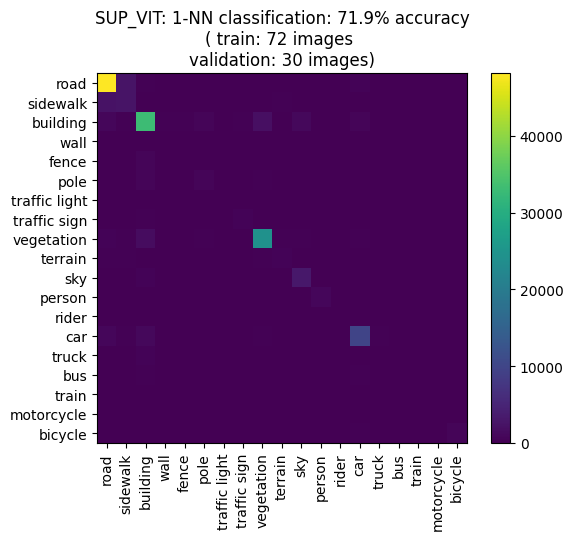

In [93]:
plt.figure()
plt.yticks(range(len(eval_labels_cs)), eval_label_names_cs)
plt.xticks(range(len(eval_labels_cs)), eval_label_names_cs, rotation=90)
plt.imshow(cm)
plt.title(f"{model.upper()}: 1-NN classification: {acc_score*100:.1f}% accuracy\n( train: {len(labels_train)//196//32} images \nvalidation: {len(labels_val)//196//32} images)")
plt.colorbar()
plt.savefig('knn_cm_.png')


In [90]:
f"{model.upper()} : {acc_score*100:.1f}"

'SUP_VIT : 71.9'

In [ ]:
predictions_val_mae = top_k.reshape(30, 64*128)

In [36]:
predictions_val_mae = top_k.reshape(960,256)

In [ ]:
predictions_val_mae.shape

In [ ]:
cv2.resize(predictions_val_mae[0].reshape(64, 128).to(float).detach().numpy(), (2048, 1024))

In [ ]:
predictions_val_mae[0].reshape(73, 146)

In [ ]:
plt.imshow(predictions_val_mae[15].reshape(64, 128))#cv2.resize(preds, (2044, 1022), interpolation=cv2.INTER_NEAREST_EXACT))

In [ ]:
a = predictions_val_mae[0].reshape(64, 128).detach().numpy()

In [37]:
annots = np.load('/home/hkhachatrian/mae/annotations/cs/cs4pc_256_val.npy', allow_pickle=True).item()
for i, preds in enumerate(predictions_val_mae):
#     preds = preds.reshape(64, 128).detach().numpy()
#     preds = cv2.resize(preds, (2048, 1024), interpolation=cv2.INTER_NEAREST_EXACT)
    annots['images'][i]['black_image_gt'] = annots['images'][i]['black_image']
    annots['images'][i]['patch_labels'] = preds.detach().numpy()
    

In [ ]:
annots = np.load('/home/hkhachatrian/mae/annotations/cs/cs_val.npy', allow_pickle=True).item()
for i, preds in enumerate(predictions_val_mae):
    preds = preds.reshape(64, 128).detach().numpy()
    preds = cv2.resize(preds, (2048, 1024), interpolation=cv2.INTER_NEAREST_EXACT)
    annots['images'][i]['black_image_gt'] = annots['images'][i]['black_image']
    annots['images'][i]['patch_labels'] = preds
    

In [38]:
np.save(f'../annotations/cs_val_{model}_knn_72_train_30_val_layer_7.npy', annots)

In [ ]:
model='mae'
path_to_knn = f'{path_to_read}predictions_knn/{model}_train_8_val_8'
labels_train = torch.from_numpy(np.load(path_to_read + f'f1m_{model}_8shot_labels_train.npy' )).to(device=device, dtype=torch.int64)
labels_val = torch.from_numpy(np.load(path_to_read + f'f1m_{model}_8shot_labels_val.npy')).to(device=device, dtype=torch.int64)

In [ ]:
labels_val.shape

In [ ]:
top_k = compute_1NN(path_to_knn, labels_train)

In [ ]:
top_k

In [ ]:
acc_score = metrics.accuracy_score(labels_val, top_k)

In [ ]:
acc_score

In [51]:
cm = metrics.confusion_matrix(labels_val, top_k, labels=eval_labels_f1)

NameError: name 'eval_labels_f1' is not defined

In [ ]:
plt.figure()
plt.imshow(cm, vmax=5000)
plt.yticks(range(len(eval_labels_f1)), eval_label_names_f1)
plt.xticks(range(len(eval_labels_f1)), eval_label_names_f1, rotation=90)
plt.title(f"{model.upper()}: 1-NN classification: {acc_score*100:.1f}% accuracy\n( train: 8 images per class \nvalidation: 32 images per class)")
plt.colorbar();

In [ ]:
preds_dino = top_k.reshape(40, 196)
preds_dino.shape

In [ ]:
annots = np.load('/mnt/lwll/lwll-coral/FAIR1M/fair1m_1000/250_8shot/val/val.npy', allow_pickle=True).item()
for i, preds in enumerate(preds_dino):
    annots['images'][i]['patch_labels_gt'] = annots['images'][i]['patch_labels']
    annots['images'][i]['patch_labels'] = preds.detach().numpy()
np.save('/mnt/lwll/lwll-coral/FAIR1M/fair1m_1000/250_8shot/val/mae_val_pred_1nn.npy', annots)

In [ ]:
np.load('/mnt/lwll/lwll-coral/FAIR1M/fair1m_1000/250_8shot/val/dino_val_pred_1nn.npy', allow_pickle=True)

In [ ]:
449280//196

In [ ]:
val_labels_ = np.load(f'/home/hkhachatrian/mae/embeddings/cs_patches_256/mae_labels_val_30.npy', allow_pickle=True)

In [ ]:
val_labels_.shape

In [ ]:
test = np.load('../annotations/cs_256_dino_knn_72_train_30_val.npy', allow_pickle=True)

In [ ]:
test

In [ ]:
None and 'asdadaf'

In [ ]:
True and 'asdadaf'

In [ ]:
# annotation_train = '/mnt/lwll/lwll-coral/FAIR1M/fair1m_1000/250_8shot/train/train.npy'
annotation_val = '/mnt/lwll/lwll-coral/FAIR1M/fair1m_1000/250_8shot/val/val.npy'

In [ ]:
f1_val = np.load(annotation_val, allow_pickle=True)

In [ ]:
len(f1_val.item()['images'])

In [ ]:
test = np.load('/mnt/lwll/lwll-coral/hrant/embeddings/fair1m/f1m_mae_8shot_embeds_val.npy', allow_pickle=True)

In [ ]:
test.shape

In [ ]:
x = torch.tensor([1, 2])

In [ ]:
x.shape

In [ ]:
x = x.unsqueeze(dim=0)

In [ ]:
x.shape

In [ ]:
# 'background', 'airplane', 'ship', 'vehicle', 'court', 'roundabout'
names = {
    0: 'background',
    1: 'airplane',
    2: 'ship',
    3: 'vehicle',
    4: 'court',
    5: 'roundabout'
}

In [ ]:
path = '/mnt/lwll/lwll-coral/FAIR1M/fair1m_1000/250_8shot/val'
# dino = np.load(path + '/dino_val_pred_1nn.npy', allow_pickle=True).item()['images']
# dino = np.load(path + '/dino_val_pred_gmm.npy', allow_pickle=True).item()['images']
# mae = np.load(path + '/mae_val_pred_1nn.npy', allow_pickle=True).item()['images']
# mae = np.load(path + '/mae_val_pred_gmm.npy', allow_pickle=True).item()['images']
# vit = np.load(path + '/sup_vit_val_pred_1nn.npy', allow_pickle=True).item()['images']
vit = np.load(path + '/sup_vit_val_pred_gmm.npy', allow_pickle=True).item()['images']

In [ ]:
dino[0]['patch_labels'], dino[0]['patch_labels_gt']

In [ ]:
dino[0]['black_image'].shape

In [ ]:
def iou(labels, labels_gt, class_number):
    ind = torch.where(labels != class_number)[0]
    labels[ind] = 0
    
    intersection = torch.logical_and(labels, labels_gt)
    union = torch.logical_or(labels, labels_gt)
    iou_score = torch.sum(intersection) / torch.sum(union)
    return iou_score

def count_mIoU(dataset, dataset_name):
    miou = []
    for class_number in range(1, 6):
        ious = []
        print('class:', dataset_name, class_number, names[class_number])
        for data in dataset:
            labels = cv2.resize(data['patch_labels'].reshape(14, 14), (250, 250), interpolation=cv2.INTER_NEAREST_EXACT)
            labels = torch.tensor(labels).flatten()
            labels_gt = torch.tensor(data['black_image'].flatten())
            ious.append(iou(labels, labels_gt, class_number))
        ious = torch.tensor(ious)
        print('{}'.format(ious[ious>0].mean().item()))
        miou.append(ious[ious>0].mean().item())
    print('mean:', torch.tensor(miou).mean().item())
    print()

In [ ]:
count_mIoU(vit, 'vit')

In [ ]:
for data, name in zip([dino, mae, vit], ['dino', 'mae', 'vit']):
    count_mIoU(data, name)

In [ ]:
ious

In [ ]:
ind = torch.where(labels != 1)[0]
labels[ind] = 0

In [ ]:
ind.shape

In [ ]:
torch.where(labels == 1)[0].shape

In [ ]:
dino[0]['patch_labels_gt'].shape

In [ ]:
labels = labels[labels==class_number]

In [ ]:
labels.shape

In [ ]:
x = cv2.resize(dino[0]['patch_labels'].reshape(14, 14), (250, 250), interpolation=cv2.INTER_NEAREST_EXACT)
plt.imshow(x);

In [24]:
train_embeds.shape

(7840, 768)

(196, 768)

ValueError: x and y must have same first dimension, but have shapes (1,) and (19, 19)

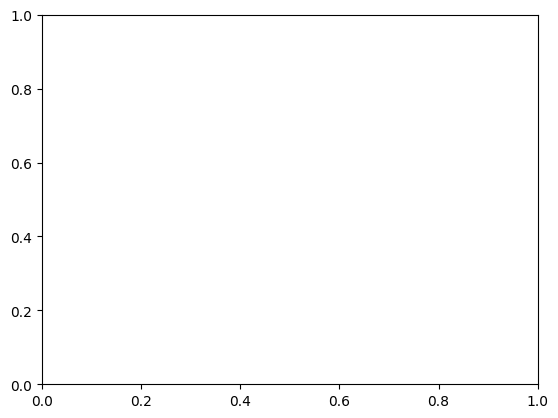

In [63]:
x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
y = [5, 7, 8, 1, 4, 9, 6, 3, 5, 2, 1, 8]
 
plt.plot(19, cm)
 
plt.xlabel('x-axis label')
plt.ylabel('y-axis label')
plt.title('Matplotlib Example')
 
plt.savefig("output.jpg")

In [73]:
os.path.join('./knn_matrixes/model_name', 'aswdas'+'.png')

'./knn_matrixes/model_name/aswdas.png'

In [71]:
if True:
    print('none')

none


In [ ]:
import os.path
os.path.isfile(fname) 

In [75]:
mycsv = CSVWriter('./test.csv')
mycsv.write(12,'green','apples')
# with open('knn_accuray.csv','a') as fd:
#     fd.write(12,'green','apples')

NameError: name 'CSVWriter' is not defined

In [77]:
np.save('knn_test.npy', {'acc': 5})

In [81]:
data = {'acc': 5}

In [79]:
np.load('knn_test.npy', allow_pickle=True)

array({'acc': 5}, dtype=object)

In [91]:
with open("test.txt", "a") as myfile:
    
    myfile.write(f"{model.upper()} : {acc_score*100:.1f}\n")

In [103]:
len(np.load('/home/hkhachatrian/mae/annotations/cs/cs_train.npy', allow_pickle=True).item()['images'])

72

In [104]:
train = np.load('/home/hkhachatrian/mae/annotations/cs/cs4pc_256_train.npy', allow_pickle=True)

In [106]:
len(train.item()['images'])

2304

In [107]:
len(labels_train)//len(train.item()['images'])

196

In [110]:
labels_train.reshape(len(train.item()['images']), -1).shape[-1]

196

In [111]:
os.path.dirname('/home/hkhachatrian/mae/embeddings/cs_patches_256/layers/dino_cs4pc_256_train_1_embeds.npy')

'/home/hkhachatrian/mae/embeddings/cs_patches_256/layers'

In [117]:
a = ''

In [118]:
f'jajndjanf{a}'

'jajndjanf'

In [122]:
labels_train.reshape(-1, 196).shape[0]//32

72

In [123]:
patch_count = labels_val.reshape(960, -1).shape[-1]

In [124]:
188160//196

960

In [130]:
np.load('/home/hkhachatrian/mae/embeddings/cs_patches_256/dino_labels_train_72.npy', allow_pickle=True).shape

(451584,)

In [128]:
3136000//196/32

500.0

In [131]:
451584//196//32

72

In [132]:
245760//256//32

30